<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Generative adversarial networks</b></h3>



В этом ноутбуке мы попробуем обучить GAN генерировать морды кошек из случайного шума. Датасет с кошками взят отсюда:
https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

In [3]:
%env NVIDIA_VISIBLE_DEVICES=1
%env CUDA_VISIBLE_DEVICES=1

!echo $NVIDIA_VISIBLE_DEVICES
!echo $CUDA_VISIBLE_DEVICES

env: NVIDIA_VISIBLE_DEVICES=1
env: CUDA_VISIBLE_DEVICES=1
1
1


In [2]:
!nvidia-smi

Thu Jan  5 02:06:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   38C    P0    53W / 300W |   4292MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [4]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import DatasetFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [5]:
# !unzip archive.zip

In [6]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [7]:
class RealImageDataset(DatasetFolder):
    def __init__(self, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.samples[index]
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [8]:
from PIL import Image
from sklearn.model_selection import train_test_split

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def get_dataloader(batch_size, folder_path, transforms):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    
    dataset = RealImageDataset(
        root=folder_path,
        transform=transforms,
        loader=pil_loader,
        extensions=('png')
    )
    
    train_idx, valid_idx = train_test_split(
        np.arange(len(dataset), dtype=np.int32),
        test_size=0.2
    )
    
    train_subset = Subset(dataset, train_idx)
    valid_subset = Subset(dataset, valid_idx)
    
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        num_workers=40,
        shuffle=True
    )
    
    val_loader = DataLoader(
        valid_subset,
        batch_size=batch_size,
        num_workers=40
    )
  

    return train_loader, val_loader

In [9]:
BATCH_SIZE = 256

In [10]:
train_loader, val_loader = get_dataloader(
    batch_size=BATCH_SIZE,
    folder_path='thumbnails',
    transforms=tt.Compose([
        tt.ToTensor(),
        tt.Normalize(*stats)
    ])
)

In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

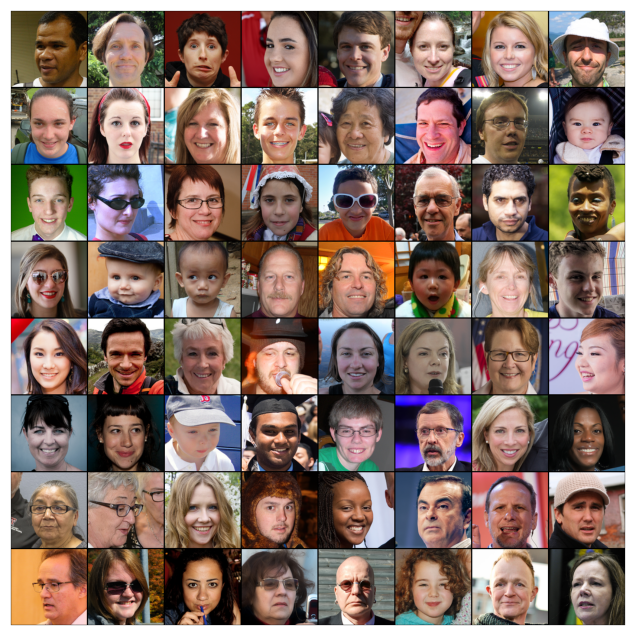

In [13]:
show_batch(train_loader)

In [14]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [16]:
from torch.nn.utils import spectral_norm

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = spectral_norm(nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=9,
            stride=2,
            bias=False
        ))

        self.conv2 = spectral_norm(nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=9,
            stride=2,
            bias=False
        ))

        self.conv3 = spectral_norm(nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=9,
            stride=2,
            bias=False
        ))

        self.conv4 = spectral_norm(nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=9,
            stride=2,
            bias=False
        ))

        self.flatten = nn.Flatten(start_dim=1)

        self.act = nn.LeakyReLU(0.2)

        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = self.flatten(self.act(self.conv4(x)))
        
        return self.fc(x)

In [18]:
# discriminator = nn.Sequential(
#     # in: 3 x 64 x 64
    
#     nn.Conv2d(
#         in_channels=3,
#         out_channels=64,
#         kernel_size=9,
#         stride=2,
#         bias=False
#     ),

#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 64 x 32 x 32

#     nn.Conv2d(
#         in_channels=64,
#         out_channels=128,
#         kernel_size=9,
#         stride=2,
#         bias=False
#     ),

#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 128 x 16 x 16

#     nn.Conv2d(
#         in_channels=128,
#         out_channels=256,
#         kernel_size=9,
#         stride=2,
#         bias=False
#     ),

#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 256 x 8 x 8

#     nn.Conv2d(
#         in_channels=256,
#         out_channels=512,
#         kernel_size=9,
#         stride=2,
#         bias=False
#     ),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     # out: 512 x 4 x 4

#     # out: 1 x 1 x 1

#     nn.Flatten(start_dim=1),
    
#     nn.Linear(512, 1),
    
# #     nn.Sigmoid()
# )

In [19]:
discriminator = Discriminator()

In [20]:
discriminator = to_device(discriminator, device)

In [21]:
latent_size = 128

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(
        in_channels=latent_size,
        out_channels=256,
        kernel_size=6,
        stride=2,
        bias=False
    ),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(
        in_channels=256,
        out_channels=256,
        kernel_size=6,
        stride=1,
        bias=False
    ),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(
        in_channels=256,
        out_channels=256,
        kernel_size=6,
        stride=2,
        bias=False
    ),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(
        in_channels=256,
        out_channels=256,
        kernel_size=6,
        stride=2,
        bias=False
    ),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(
        in_channels=256,
        out_channels=128,
        kernel_size=6,
        stride=1,
        bias=False
    ),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(
        in_channels=128,
        out_channels=64,
        kernel_size=6,
        stride=2,
        bias=False
    ),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(
        in_channels=64,
        out_channels=3,
        kernel_size=3,
        stride=1,
        bias=False
    ),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([1, 3, 128, 128])


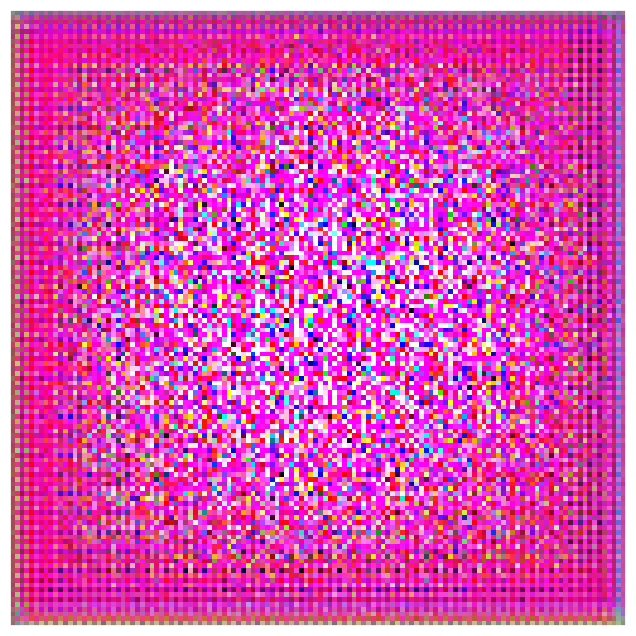

In [23]:
xb = torch.randn(1, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
generator = to_device(generator, device)

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
fixed_latent = torch.randn(20, latent_size, 1, 1, device=device)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.axis('off')
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [28]:
from IPython.display import clear_output
import gc

In [259]:
def fit(model, loader, criterion, epochs, lr_g, lr_d, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    gc.collect()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr_d, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr_g, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(loader):
            
            real_images = real_images.to(device)
            
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        clear_output(wait=True)
        
        _, axes = plt.subplots(ncols=3, figsize=(13, 5))
        
        axes[0].plot(losses_g, label='Generator loss')
        axes[0].plot(losses_d, label='Discriminator loss')
        
        axes[1].plot(real_scores, label='Real scores')
        axes[1].plot(fake_scores, label='False scores')
        
        with torch.no_grad():
                                    
            axes[2].imshow(
                make_grid(denorm(fake_images[:9]), nrow=3).cpu().permute(1, 2, 0).numpy(),
                interpolation='nearest'
            )
            
            axes[2].set_title('Generated')
            axes[2].axis('off')     

        
        axes[0].legend()
        axes[1].legend()     
        
        plt.tight_layout()
        plt.show()
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [260]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.MSELoss(),
    "generator": nn.MSELoss()
}
epochs = 100

In [261]:
torch.cuda.empty_cache()
gc.collect()

93604

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

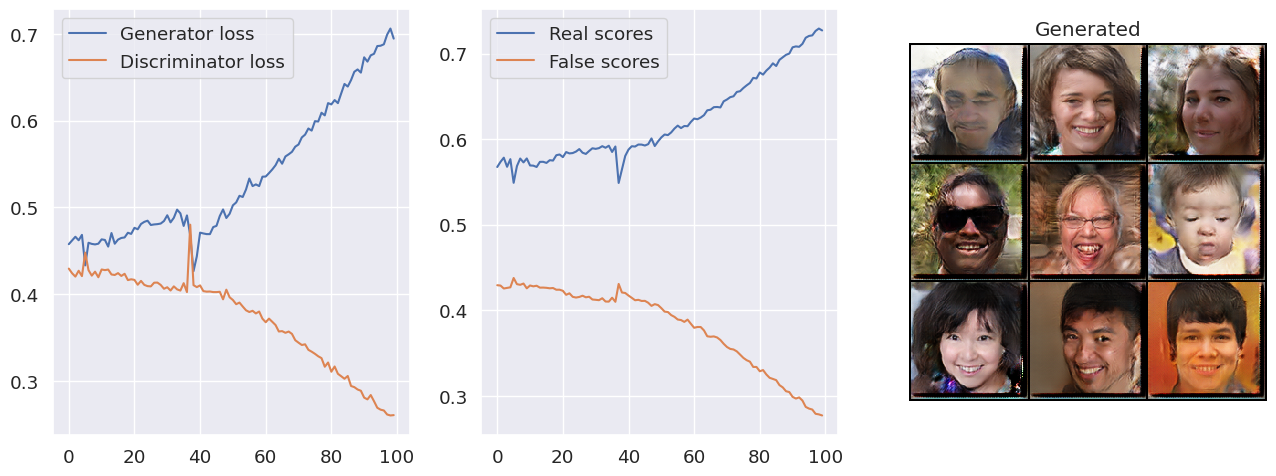

Epoch [100/100], loss_g: 0.6947, loss_d: 0.2605, real_score: 0.7270, fake_score: 0.2769
Saving generated-images-0100.png


In [262]:
history = fit(model, train_loader, criterion, epochs, lr_g=1e-4, lr_d=5e-4)

#### В идеале нельзя судить о качестве обучения, пользуясь accuracy, потому что при так называемом Mode Collapse графики не будут отличаться от случая гипотетически идеального, при котором Генератор будет путать Дискриминатор(вероятности предсказания искуственных/настоящих картинок сойдутся к 0.5).

Посмотрим на результаты обучения. Вот так выглядят котики, сгенерированные на последней эпохе обучения:

In [126]:
losses_g, losses_d, real_scores, fake_scores = history

In [127]:
!ls ./generated

generated-images-0005.png  generated-images-0040.png
generated-images-0030.png  generated-images-0200.png


In [263]:
generated_img = cv2.imread(f'./generated/generated-images-{str(epochs).zfill(4)}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

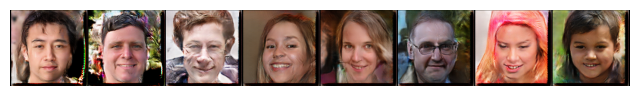

In [361]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(generated_img[:128])
ax.axis('off')

plt.show()

Поведение графиков примерно такое же, как было показано на лекции

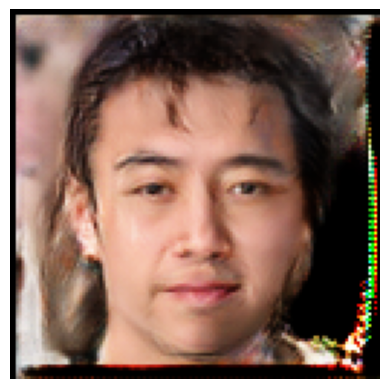

In [265]:
plt.imshow(generated_img[:128, :128])

plt.axis('off')

plt.show()

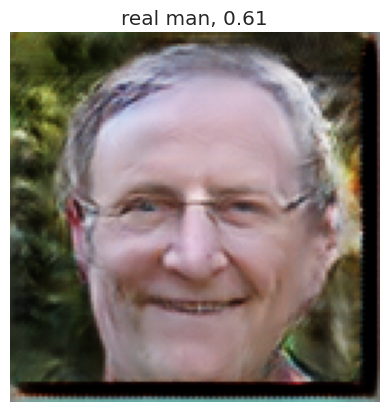

In [325]:
model['discriminator'].eval()
model['generator'].eval()

with torch.no_grad():

    z = torch.randn(1, latent_size, 1, 1, device=device) 
    fake_image = model['generator'](z)
    
    res = model['discriminator'](fake_image)
    
    plt.imshow(denorm(fake_image).squeeze().permute(1, 2, 0).cpu().numpy())
    
    ans = 'real man'
    
    if res < 0.5:
        ans = 'fake man'
        
        
    plt.axis('off')
    
    plt.title(f'{ans}, {res.item():.2f}')

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [285]:
n_images = 24

fixed_latent = torch.randn(n_images, 128, 1, 1, device=device)

with torch.no_grad():
    print(fixed_latent.device)
    fake_images = model['generator'](fixed_latent)

cuda:0


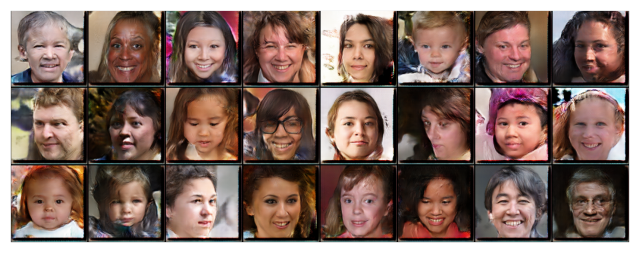

In [286]:
show_images(fake_images)

Как вам качество получившихся изображений?

#### В углах и на картинке встречаются артефакты, появление которых вызвано, в предположении, побатчевой нормализацией в Генераторе, а также деконволюциями без отступов(padding).

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [77]:
len(train_loader.dataset)

56000

In [78]:
train_loader.batch_size

256

In [287]:
torch.cuda.empty_cache()
gc.collect()

178928

In [288]:
from torchvision.models import inception_v3


feat_extractor = inception_v3(pretrained=True, init_weights=True, aux_logits=False)
feat_extractor.fc = nn.Identity()

feat_extractor.to(device)
pass

In [289]:
n_images = 1000#len(train_loader.dataset)

fake_feats = []

with torch.no_grad():
    
    for i in tqdm(range(0, n_images, BATCH_SIZE)):
    
        gen_num = min(n_images-i, BATCH_SIZE)

        fixed_latent = torch.randn(gen_num, 128, 1, 1, device=device)
        
        out = model['generator'](fixed_latent)
        
        fake_feats.append(feat_extractor(out).cpu())
        
fake_feats = torch.cat(fake_feats)
fake_feats.shape

  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([1000, 2048])

In [290]:
real_feats = []

with torch.no_grad():
    
    for batch in tqdm(train_loader):
        
        batch = batch.to(device)
    
        real_feats.append(feat_extractor(batch).cpu())
        
real_feats = torch.cat(real_feats)
real_feats = real_feats[:1000]
real_feats.shape

  0%|          | 0/219 [00:00<?, ?it/s]

torch.Size([1000, 2048])

In [291]:
real_labels = torch.ones(1000)
real_labels.shape

torch.Size([1000])

In [292]:
fake_labels = torch.zeros(1000)
fake_labels.shape

torch.Size([1000])

In [293]:
X = torch.cat([real_feats, fake_feats])
X.shape

torch.Size([2000, 2048])

In [294]:
y = torch.cat([real_labels, fake_labels])
y.shape

torch.Size([2000])

In [295]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

loo = LeaveOneOut()
loo.get_n_splits(X)

2000

In [296]:
preds = []

for i, (train_index, test_index) in tqdm(enumerate(loo.split(X)), total=loo.get_n_splits(X)):
    
    knn_clf = KNeighborsClassifier(n_neighbors=1)
    knn_clf.fit(X[train_index], y[train_index])
    
    y_pred = knn_clf.predict(X[test_index])
    
    preds.append(y_pred)


  0%|          | 0/2000 [00:00<?, ?it/s]

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

In [297]:
from sklearn.metrics import accuracy_score

In [298]:
accuracy_score(preds, y)

0.5

#### Как было описано выше, в идельном сценарии Дискриминатор не может отличить искуственные данные от реальных, что приведет к "случайному" предсказанию классов, соответствующего вероятности 0.5. Таким образом, получился близкий к идеальному результат, хотя судя по accuracy нельзя наверняка быть уверенным в качестве получившейся модели. В качестве альтернативы каноничным является подход с максимизацией метрик Inception Score, Frechet Inception Distance и тд.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображениям

In [299]:
from sklearn.manifold import TSNE

In [300]:
latent_embedded = TSNE(n_components=2).fit_transform(X)

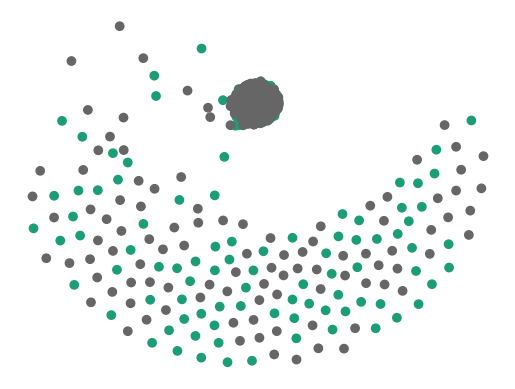

In [355]:
plt.scatter(
    latent_embedded[:, 0],
    latent_embedded[:, 1],
    c=y, cmap='Dark2_r'
)

plt.axis('off')

plt.show()

Прокомментируйте получившийся результат:

#### Визуально получились почти полностью пересеккающиеся кластеры данных, рпинадлежащих к двум классам, за редким исключением в виде выбросов. Судя по данному результату, мы хорошо приблизили искуственные данные к реальным в смысле распределения.